In [1]:
import tensorflow as tf
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from block_diag import block_diagonal
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv_folder = '../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [3]:
training_set = dataset.get_training_set()

In [4]:
training_set.keys()

dict_keys(['covariates', 'outcomes'])

In [5]:
training_set['outcomes'].sum().sort_values(ascending=False).head()

Mourning Dove           1356
American Robin          1341
Red-winged Blackbird    1283
Brown-headed Cowbird    1229
American Crow           1224
dtype: int64

In [6]:
training_set['outcomes'].shape

(1612, 371)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Brown-headed Cowbird']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:500, :]
outcomes = outcomes.values[:500, :1]

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
covariates.shape

(500, 8)

In [9]:
n_features = covariates.shape[1]
n_outcomes = outcomes.shape[1]
kern_size = covariates.shape[0] * n_outcomes

In [10]:
# Next steps:
# 1. Implement the ARD RBF kernel in tensorflow.
# 2. Implement the site kernel in tensorflow (should have derivation). --> Actually, defer this for now and just use the ARD.
# 3. Check that they look reasonable, maybe even on a super-small set.
# 4. Try to optimise with fixed hyperparameters.
# 5. Try to optimise the hyperparameters in an outer loop (Laplace approx.).
# 6. Compare speeds of sparse vs. non-sparse versions.

In [11]:
# Invent some length scales and variances
lengthscales = np.array([
    [4., 5., 2., 8., 3., 9., 5., 3.],
    [2., 8., 9., 3., 3., 4., 9., 7.]
])

alphas = np.array([1., 2.])

In [12]:
# Let's check what should happen with GPFLow
import gpflow

kern = gpflow.kernels.RBF(8, active_dims=range(8), lengthscales=lengthscales[0, :],
                          variance=alphas[0]**2)
kern.lengthscales.set_trainable(False)
kern.variance.set_trainable(False)
likelihood = gpflow.likelihoods.Bernoulli()

model = gpflow.models.VGP(covariates.astype(np.float64), outcomes[:, [0]].astype(np.float64), kern=kern, 
                          likelihood=likelihood)

gpflow.train.ScipyOptimizer().minimize(model, maxiter=100, disp=True)

pred = model.predict_f(covariates.astype(np.float64))[0]

model.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 192.982645
  Number of iterations: 38
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 192.982645
  Number of iterations: 38
  Number of functions evaluations: 43


,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,False,(),True,1.0
VGP/kern/lengthscales,Parameter,None,+ve,False,"(8,)",True,"[4.0, 5.0, 2.0, 8.0, 3.0, 9.0, 5.0, 3.0]"
VGP/q_mu,Parameter,None,(none),True,"(500, 1)",True,"[[0.23538758788056366], [2.3149350597008214], ..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 500, 500)",True,"[[[0.2246174114819431, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [13]:
k_sess = kern.enquire_session()
gpflow_kernel = k_sess.run(kern.K(covariates.astype(np.float64)))

In [14]:


#block_kernel = sess.run(block_kern, feed_dict={X: covariates})

In [15]:
#plt.matshow(block_kernel)
#plt.colorbar()

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_features))
y = tf.placeholder(tf.int64, shape=(None, n_outcomes))

y_flat = tf.cast(tf.reshape(y, (-1,)), tf.float32)

tf_scales = tf.Variable(initial_value=lengthscales, dtype=tf.float32)
tf_alphas = tf.Variable(initial_value=alphas, dtype=tf.float32)

ks = list()

# Maybe there would be a more efficient way for large numbers of species than doing it via this list.

for cur_k in range(n_outcomes):
    
    cur_scales = tf_scales[cur_k, :]
    cur_alpha = tf_alphas[cur_k]    
    cur_kernel = ard_rbf_kernel(X, X, cur_scales, cur_alpha)
    ks.append(cur_kernel)
    
block_kern = block_diagonal(ks)

In [17]:
f = tf.get_variable('f', shape=(kern_size, 1), initializer=tf.random_normal_initializer(stddev=0.01))

In [18]:
inv_kernel = tf.linalg.inv(block_kern)

In [19]:
log_prior = -0.5 * tf.matmul(tf.matmul(tf.transpose(f), inv_kernel), f)

# Log likelihood
log_lik = tf.reduce_sum(tf.expand_dims(y_flat, 1) * f - tf.nn.softplus(f))
log_post = tf.squeeze(log_prior) + log_lik
log_lik_naive = tf.expand_dims(y_flat, 1) * tf.log_sigmoid(f) + (1 - tf.expand_dims(y_flat, 1)) * tf.log(1 - tf.sigmoid(f))

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
optimiser = tf.contrib.opt.ScipyOptimizerInterface(
    -log_post, var_list=[f], options={'maxiter': 1000, 'disp': True})

In [21]:
non_gpflow_k = sess.run(ks[0], feed_dict={X: covariates})

(array([249500.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    500.]),
 array([-9.42243907e-08,  9.16556081e-07,  1.92733655e-06,  2.93811702e-06,
         3.94889749e-06,  4.95967797e-06,  5.97045844e-06,  6.98123891e-06,
         7.99201938e-06,  9.00279985e-06,  1.00135803e-05]),
 <a list of 10 Patch objects>)

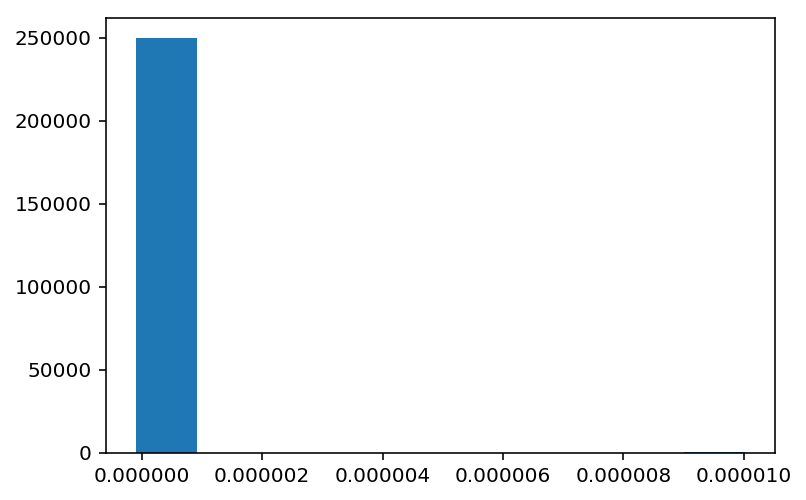

In [22]:
plt.hist((non_gpflow_k - gpflow_kernel).reshape(-1))

In [23]:
probs = tf.nn.sigmoid(f)
W = -probs * (probs - 1)
W_sqrt = tf.diag(tf.squeeze(tf.sqrt(W)))
multiplied = tf.matmul(tf.matmul(W_sqrt, block_kern), W_sqrt)

# Add on the identity
with_id = tf.eye(kern_size) + multiplied
det_term = tf.linalg.logdet(with_id)

In [24]:
log_marg_lik = tf.squeeze(log_prior) + log_lik - 0.5 * det_term

marg_opt = tf.contrib.opt.ScipyOptimizerInterface(
    -log_marg_lik, var_list=[tf_alphas, tf_scales], options={'maxiter': 100, 'disp': True})

In [25]:
optimiser.minimize(sess, feed_dict={X: covariates, y: outcomes})

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 241.863388
  Number of iterations: 308
  Number of functions evaluations: 338


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 241.863388
  Number of iterations: 308
  Number of functions evaluations: 338


In [26]:
f_opt = sess.run(f).reshape(-1, 1)

Text(0,0.5,'VGP')

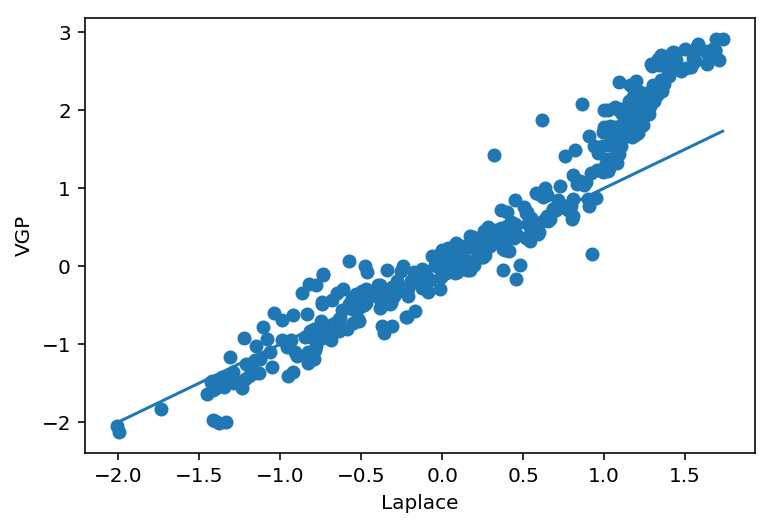

In [27]:
plt.scatter(np.squeeze(f_opt[:, 0]), np.squeeze(pred))
plt.plot([np.min(f_opt), np.max(f_opt)], [np.min(f_opt), np.max(f_opt)])
plt.xlabel('Laplace')
plt.ylabel('VGP')